### EXECUTIVE SUMMARY
This notebook has 2 tasks:
1. determine factors impact salary of data-related jobs
2. determine factors distinguish categories of data-related jobs
    
Data was scrapped from seek.com by keywords (data analyst, data engineer, data scientist, data architect) in Australia, which returned 13965 jobs. After dropping irrelevant jobs and duplicates, 5130 observations were kept for machine learning. 
    
For task 1, target variable is salary range, which has been classified as low(80k and under), mid(80k - 120k) and high(120k and above) with reletively balanced distribution. The hypothsis was that location, industry, employment type would impact on salary band. 65% accuracy was returned from LogisticRegression model taking these features into account, whereas 62% accuracy when learning from job description only. 
    
The findings are below:
- Contract/temporary employment is more likely to offer high salary, whereas full-time employment is more popular for mid and low salary range.
- With high salary band, employers are looking for senior business and architect experience. In low salary band, employees are expected to be junior, graduate and supportive role. 
- Location-wise, ACT, Melbourne and Sydney offer the most high salary data related jobs. On the other hand, Brisbane and Adelaide offer low salary jobs. 
- Industry-wise, employers labelled as Information and Communication Technology tend to offer high salary for data-related jobs. By that, it means that employers in other industries are more likely to offer lower salary. 
    
For task 2, target variable is job categories (analyst, scientist, engineer, architect) where 65% jobs were listed as analyst. One finding was that job description of these categories were most likely to include similar terms or word roots in text, resulting in high biased model with 94% accuary. The approach of this task was to get rid of these relevant terms from document term matrix before machine learning. It reduced accuracy to 89% however generated more intelligent interpretation. 
    
The findings are below:
- Architect roles are expected to demonstrate abilities of solution delivery, roadmaps, leadership and engagement. 
- Scientist roles are described with statistical and algorithm knowledge, prediction and technical abilities.
- Engineer roles heavily involve Python language, knowledge of AWS, data pipeline, and deployment.
- Analyst roles are associated with understanding of business and reporting skills. 

### PART1. EDA

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.html.use_mathjax', False)

In [2]:
data_analyst = pd.read_json('./datasets/data_analyst.json')
data_scientist = pd.read_json('./datasets/data_scientist_1.json')
data_architect = pd.read_json('./datasets/data_architect_1.json')
data_engineer = pd.read_json('./datasets/data_engineer_1.json')

df = pd.concat([data_analyst, data_scientist, data_architect, data_engineer], axis = 0)
df.shape

(13965, 12)

In [3]:
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13965 entries, 0 to 13964
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           13965 non-null  int64 
 1   title            13965 non-null  object
 2   company          7694 non-null   object
 3   city             13965 non-null  object
 4   suburb           9133 non-null   object
 5   industry         13965 non-null  object
 6   department       13965 non-null  object
 7   salary           4701 non-null   object
 8   salary_label     13965 non-null  object
 9   employment_type  13965 non-null  object
 10  detail           13965 non-null  object
 11  request_url      13965 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.3+ MB


In [4]:
def column_inspector(df):
    for col in df.columns[:-2]:
        print('----------------', col.upper(),'----------------')
        print(df[col].value_counts(dropna = False))
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

In [5]:
column_inspector(df)

---------------- JOB_ID ----------------
52570370    4
52409085    4
52431789    4
52552486    4
52360696    4
           ..
52343314    1
52569926    1
52500296    1
52387657    1
52545535    1
Name: job_id, Length: 11091, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

---------------- TITLE ----------------
Data Engineer                                270
Business Analyst                             232
Solution Architect                           103
Senior Business Analyst                      101
Senior Data Engineer                          98
                                            ... 
Salesforce Functional Analyst                  1
Financial Accountant- Fixed Term Contract      1
APS6 Risk Enablement Officer                   1
Executive Assistant & Office Manager           1
Data Engineer- MS Azure                        1
Name: title, Length: 7399, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

---------------- COMPANY ----------------


#### Filter job title by 4 categories: 'analyst'/'scientist'/'engineer'/'architect', drop unrelevant jobs by title

In [6]:
title_stings = ['analyst','scientist','engineer', 'architect']

relevant_title_idx = []
for idx, ttl in enumerate(df.title):
    ttl_words = [x for x in ttl.split()]
    for ttl_word in ttl_words:
        if ttl_word.lower() in title_stings:
            relevant_title_idx.append(idx)
            break

df1 = df.iloc[relevant_title_idx,:]
df1.shape

(6620, 12)

#### Remove duplicate jobs by job_id

In [7]:
job_ids = df1.job_id.tolist()

keep_id_list = []
for job_id in list(dict.fromkeys(job_ids)):
    index = df1[df1.job_id == job_id].index
    keep_id_list.append(index[0])

df2 = df.iloc[keep_id_list,:]
df2.shape

(5134, 12)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5134 entries, 0 to 13962
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           5134 non-null   int64 
 1   title            5134 non-null   object
 2   company          2997 non-null   object
 3   city             5134 non-null   object
 4   suburb           3484 non-null   object
 5   industry         5134 non-null   object
 6   department       5134 non-null   object
 7   salary           1710 non-null   object
 8   salary_label     5134 non-null   object
 9   employment_type  5134 non-null   object
 10  detail           5134 non-null   object
 11  request_url      5134 non-null   object
dtypes: int64(1), object(11)
memory usage: 521.4+ KB


#### Remove "outliers" where value counts is extremely low

In [9]:
df2[df2.suburb == 'India & South Asia'].request_url
# keeping this job as it involved database knowledge

9395    https://www.seek.com.au/job/52575179?type=stan...
Name: request_url, dtype: object

In [10]:
df2[df2.industry == 'Trades & Services'].request_url
# not data related job >>> drop it

6043    https://www.seek.com.au/job/52521662?type=stan...
Name: request_url, dtype: object

In [11]:
df2[df2.industry == 'Farming, Animals & Conservation'].request_url
# not data related job >>> drop it

8353    https://www.seek.com.au/job/52586209?type=stan...
Name: request_url, dtype: object

In [12]:
df2[df2.industry == 'Hospitality & Tourism'].request_url
# not data related job >>> drop it

1233    https://www.seek.com.au/job/52363026?type=stan...
5246    https://www.seek.com.au/job/52579999?type=stan...
Name: request_url, dtype: object

In [13]:
df2.drop(index = [6043,8353,1233,5246], inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
df2.reset_index(inplace = True, drop = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           5130 non-null   int64 
 1   title            5130 non-null   object
 2   company          2995 non-null   object
 3   city             5130 non-null   object
 4   suburb           3481 non-null   object
 5   industry         5130 non-null   object
 6   department       5130 non-null   object
 7   salary           1708 non-null   object
 8   salary_label     5130 non-null   object
 9   employment_type  5130 non-null   object
 10  detail           5130 non-null   object
 11  request_url      5130 non-null   object
dtypes: int64(1), object(11)
memory usage: 481.1+ KB


In [15]:
df2.head()

,job_id,title,company,city,suburb,industry,department,salary,salary_label,employment_type,detail,request_url
0,52624020,Data & Reporting Analyst,Tony White Group,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,None,low,Full Time,THE TONY WHITE GROUP: The Tony White Group (TW...,https://www.seek.com.au/job/52624020?type=stan...
1,52586658,Data Analyst,None,Sydney,"CBD, Inner West & Eastern Suburbs",Government & Defence,Government - Federal,Access to a wide-range of staff benefits,low,Full Time,\n Work on a high impact transformation using ...,https://www.seek.com.au/job/52586658?type=stan...
2,52630549,Data Analyst,Australian Financial Complaints Authority Limited,Melbourne,CBD & Inner Suburbs,Banking & Financial Services,Analysis & Reporting,Base + Super + Not-for-profit benefits,low,Full Time,The General Insurance Code Compliance team at ...,https://www.seek.com.au/job/52630549?type=stan...
3,52581764,Junior Data Analyst,Continuum Recruitment,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Other,"Great salary, amazing mentor",low,Full Time,Growing internal team Advancing Technology Lea...,https://www.seek.com.au/job/52581764?type=stan...
4,52631079,Data Analyst,None,Brisbane,CBD & Inner Suburbs,Accounting,Analysis & Reporting,None,low,Full Time,About Ashurst: Ashurst is a leading g...,https://www.seek.com.au/job/52631079?type=stan...


### PART2. Predict salary class by job description, location, title, company, industry, employment_type

#### merge text columns(job title and detail), dummy categorical features

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [17]:
# label salary range:
# 0: low (80,000 and under)
# 1: mid (80,000 to 120,000)
# 2: high (120,000 and above)

df2.salary_label = df2.salary_label.map(lambda x: 2 if x == 'high' else(1 if x =='mid' else 0))
df2.reset_index(inplace=True, drop=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
# define predictors and target

X = df2[['city','suburb','industry','department','employment_type','title','detail']]
y = df2.salary_label

In [19]:
df2.salary_label.value_counts(normalize=True)
# baseline is 37%

1    0.371930
0    0.326901
2    0.301170
Name: salary_label, dtype: float64

In [20]:
# merge title and detail together

X['merged_text'] = X.title + ' ' + X.detail

X.drop(['title','detail'], axis = 1, inplace=True)
X.head(2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,city,suburb,industry,department,employment_type,merged_text
0,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,Full Time,Data & Reporting Analyst THE TONY WHITE GROUP:...
1,Sydney,"CBD, Inner West & Eastern Suburbs",Government & Defence,Government - Federal,Full Time,Data Analyst \n Work on a high impact transfor...


In [21]:
# dummy city, suburb, industry, department, employment_type, title_label
dummy_cols = ['city','suburb','industry','department','employment_type']
dummied_X = pd.get_dummies(X, columns=dummy_cols)
dummied_X.head(2)

,merged_text,city_ACT,city_Adelaide,city_Albany & Great Southern,city_Albury Area,city_Asia Pacific,city_Ballarat & Central Highlands,"city_Bendigo, Goldfields & Macedon Ranges",city_Blue Mountains & Central West,city_Brisbane,...,department_Underwriting,"department_Warehousing, Storage & Distribution",department_Water & Waste Engineering,department_Web & Interaction Design,department_Web Development & Production,department_Workers' Compensation,employment_type_Casual/Vacation,employment_type_Contract/Temp,employment_type_Full Time,employment_type_Part Time
0,Data & Reporting Analyst THE TONY WHITE GROUP:...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,Data Analyst \n Work on a high impact transfor...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(dummied_X, y, test_size=.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((4104, 241), (1026, 241))

In [23]:
jd_train = X_train.merged_text
jd_test = X_test.merged_text

#### generate 2 document term matrixes with different ngram range, merge back to dummies variables

In [24]:
# initialise CountVectorizer 1
cv1 = CountVectorizer(max_df=0.3, max_features=5000, min_df=1, ngram_range=(1,1), stop_words='english')

# transform train and test dataset
jd_train_cv1 = cv1.fit_transform(jd_train)
jd_test_cv1 = cv1.transform(jd_test)

# merge transformed dtm to dummied features
cv1_train = pd.DataFrame(data = jd_train_cv1.toarray(), columns=cv1.get_feature_names())
cv1_test = pd.DataFrame(data = jd_test_cv1.toarray(), columns=cv1.get_feature_names())

X_train_cv1 = X_train.merge(cv1_train, on = X_train.index)
X_train_cv1.drop(['key_0','merged_text'], axis =1, inplace=True)

X_test_cv1 = X_test.merge(cv1_test, on = X_test.index)
X_test_cv1.drop(['key_0','merged_text'], axis =1, inplace=True)

# normalise train and test dataset
Xn_train_cv1 = Normalizer().fit_transform(X_train_cv1)
Xn_test_cv1 = Normalizer().transform(X_test_cv1)   

X_train_cv1.shape, X_test_cv1.shape

((4104, 5240), (1026, 5240))

In [25]:
# initialise CountVectorizer 2 and repeat above steps
cv2 = CountVectorizer(max_df=0.3, max_features=10000, min_df=1, ngram_range=(1,2), stop_words='english')

jd_train_cv2 = cv2.fit_transform(jd_train)
jd_test_cv2 = cv2.transform(jd_test)

cv2_train = pd.DataFrame(data = jd_train_cv2.toarray(), columns=cv2.get_feature_names())
cv2_test = pd.DataFrame(data = jd_test_cv2.toarray(), columns=cv2.get_feature_names())

X_train_cv2 = X_train.merge(cv2_train, on = X_train.index)
X_train_cv2.drop(['key_0','merged_text'], axis =1, inplace=True)

X_test_cv2 = X_test.merge(cv2_test, on = X_test.index)
X_test_cv2.drop(['key_0','merged_text'], axis =1, inplace=True)

# normalise
Xn_train_cv2 = Normalizer().fit_transform(X_train_cv2)
Xn_test_cv2 = Normalizer().transform(X_test_cv2)  

X_train_cv2.shape, X_test_cv2.shape

((4104, 10240), (1026, 10240))

In [26]:
# create a function to call classification report faster
def class_report(model, y_true, X_test):
    print(metrics.classification_report(y_true, model.predict(X_test)))

#### fit logistic regression on both transformed dataset

In [27]:
lr_gs1 = GridSearchCV(LogisticRegression(random_state=42), 
                       param_grid={"C":[0.001,0.01,0.1,1], 'max_iter':[100,200,300,400,500]},
                      cv = 5,
                      n_jobs=-1,
                      verbose=1)

lr_gs1.fit(Xn_train_cv1, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': [100, 200, 300, 400, 500]},
             verbose=1)

In [28]:
class_report(lr_gs1, y_test, Xn_test_cv1)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       335
           1       0.57      0.61      0.59       382
           2       0.70      0.65      0.67       309

    accuracy                           0.64      1026
   macro avg       0.65      0.64      0.64      1026
weighted avg       0.64      0.64      0.64      1026



In [29]:
lr_gs2 = GridSearchCV(LogisticRegression(random_state=42), 
                       param_grid={"C":[0.001,0.01,0.1,1], 'max_iter':[100,200,300,400,500]},
                      cv = 5,
                      n_jobs=-1,
                      verbose=1)

lr_gs2.fit(Xn_train_cv2, y_train)
class_report(lr_gs2, y_test, Xn_test_cv2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       335
           1       0.58      0.62      0.60       382
           2       0.69      0.66      0.67       309

    accuracy                           0.65      1026
   macro avg       0.66      0.65      0.65      1026
weighted avg       0.65      0.65      0.65      1026



In [30]:
lr_gs2.best_score_

0.635478149787588

#### Logistic regression does better on the second dataset where ngram_range is (1,2), inspect the coefficients and visualise the top features/tokens

In [31]:
tokens = X_train_cv2.columns
importances_low = lr_gs2.best_estimator_.coef_[0]
importances_mid = lr_gs2.best_estimator_.coef_[1]
importances_high = lr_gs2.best_estimator_.coef_[2]

lr_gs2_df = pd.DataFrame({'token': tokens,
                           'low_coef': importances_low,
                           'low_coef_abs': abs(importances_low),
                           'mid_coef': importances_mid,
                           'mid_coef_abs': abs(importances_mid),
                           'high_coef': importances_high,
                           'high_coef_abs': abs(importances_high),})

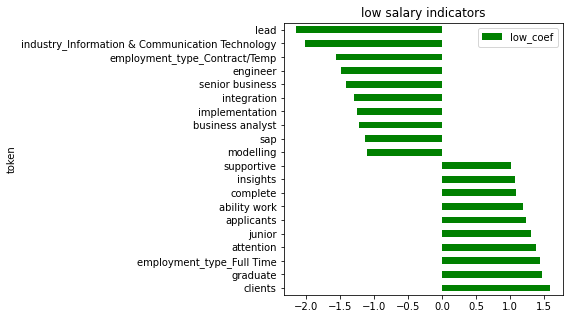

In [32]:
low_salary = lr_gs2_df[['token','low_coef','low_coef_abs']].sort_values('low_coef', ascending=False)
low_salary_top = low_salary[:10]
low_salary_bottom = low_salary[-10:]
low_salary_merge = pd.concat([low_salary_top, low_salary_bottom])
low_salary_merge.plot(kind = 'barh',
              x = 'token',
              y = 'low_coef',
              title = 'low salary indicators',
              color = 'green',figsize = (5,5));

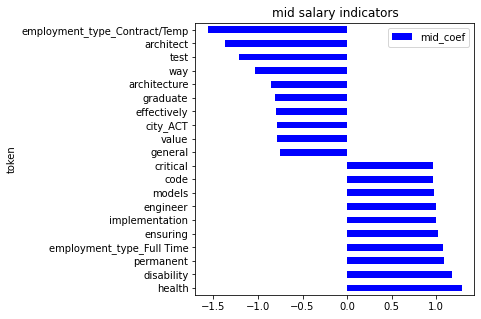

In [33]:
mid_salary = lr_gs2_df[['token','mid_coef','mid_coef_abs']].sort_values('mid_coef', ascending=False)

mid_salary_top = mid_salary[:10]
mid_salary_bottom = mid_salary[-10:]
mid_salary_merge = pd.concat([mid_salary_top, mid_salary_bottom])
mid_salary_merge.plot(kind = 'barh',
              x = 'token',
              y = 'mid_coef',
              title = 'mid salary indicators',
              color = 'blue',figsize = (5,5));

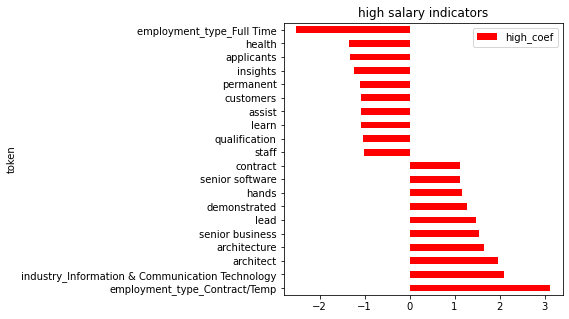

In [34]:
high_salary = lr_gs2_df[['token','high_coef','high_coef_abs']].sort_values('high_coef', ascending=False)
high_salary_top = high_salary[:10]
high_salary_bottom = high_salary[-10:]
high_salary_merge = pd.concat([high_salary_top, high_salary_bottom])
high_salary_merge.plot(kind = 'barh',
              x = 'token',
              y = 'high_coef',
              title = 'high salary indicators',
              color = 'red',figsize = (5,5));

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:ylabel='token'>

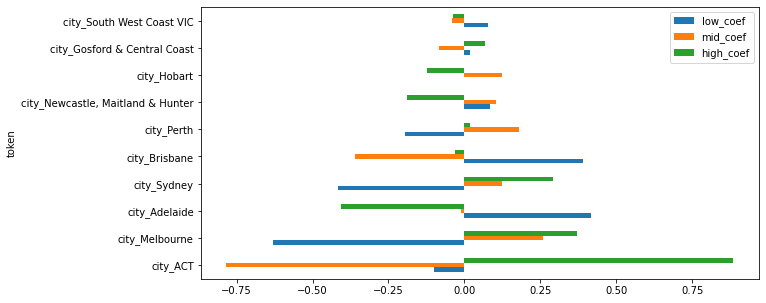

In [35]:
city_idx = [idx for idx, tk in enumerate(lr_gs2_df.token) if 'city_' in tk]
city_importance = lr_gs2_df.iloc[city_idx,:]

city_importance['total_coef'] = city_importance.low_coef_abs + city_importance.mid_coef_abs + city_importance.high_coef_abs
city_importance.sort_values('total_coef', ascending=False)[:10].plot(kind='barh',x='token', y=['low_coef','mid_coef','high_coef'], figsize = (10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='token'>

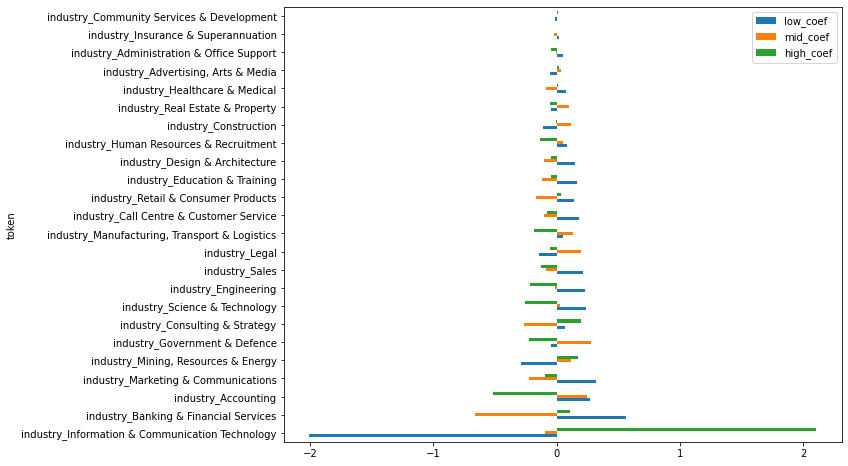

In [36]:
industry_idx = [idx for idx, tk in enumerate(lr_gs2_df.token) if 'industry_' in tk]
industry_importance = lr_gs2_df.iloc[industry_idx,:]
industry_importance['total_coef'] = industry_importance.low_coef_abs + industry_importance.mid_coef_abs + industry_importance.high_coef_abs
industry_importance.sort_values('total_coef', ascending=False).plot(kind='barh',x='token', y=['low_coef','mid_coef','high_coef'], figsize = (10,8))

#### fit RandomForestClassifier on both transformed dataset

In [37]:
# fit first dateset

rfc_params = {'max_depth': [8,12],
             'max_features':[10,20],
             'min_samples_split':[5,8],
             'n_estimators': [1000,1500]}

rfc_gs1 = GridSearchCV(RandomForestClassifier(random_state=42), rfc_params, cv = 5, n_jobs = -1, verbose=1)
rfc_gs1.fit(Xn_train_cv1, y_train)

class_report(rfc_gs1, y_test, Xn_test_cv1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
              precision    recall  f1-score   support

           0       0.78      0.50      0.61       335
           1       0.52      0.76      0.62       382
           2       0.72      0.61      0.66       309

    accuracy                           0.63      1026
   macro avg       0.67      0.62      0.63      1026
weighted avg       0.67      0.63      0.63      1026



In [38]:
rfc_gs1.best_estimator_, rfc_gs1.best_score_

(RandomForestClassifier(max_depth=12, max_features=20, min_samples_split=5,
                        n_estimators=1500, random_state=42),
 0.6269501797332223)

In [39]:
# fit second dataset

rfc_gs2 = GridSearchCV(RandomForestClassifier(random_state=42), rfc_params, cv = 5, n_jobs = -1, verbose=1)
rfc_gs2.fit(Xn_train_cv2, y_train)

class_report(rfc_gs2, y_test, Xn_test_cv2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
              precision    recall  f1-score   support

           0       0.80      0.43      0.56       335
           1       0.49      0.83      0.62       382
           2       0.77      0.51      0.62       309

    accuracy                           0.60      1026
   macro avg       0.69      0.59      0.60      1026
weighted avg       0.68      0.60      0.60      1026



In [40]:
rfc_gs2.best_estimator_, rfc_gs2.best_score_

(RandomForestClassifier(max_depth=12, max_features=20, min_samples_split=8,
                        n_estimators=1500, random_state=42),
 0.5996598437360744)

#### randomforest classifier does better on ngram range = (1,1), inspect the feature importance

In [41]:
rfc_gs1_df = pd.DataFrame({'token': X_train_cv1.columns,
                           'importance': rfc_gs1.best_estimator_.feature_importances_})
rfc_gs1_df.sort_values('importance', ascending=False)[:20]

,token,importance
237,employment_type_Contract/Temp,0.011426
78,industry_Information & Communication Technology,0.010431
238,employment_type_Full Time,0.010175
669,architect,0.008400
674,architecture,0.008326
96,department_Architects,0.008000
4483,solution,0.006792
1389,contract,0.005534
2691,integration,0.004631
749,attention,0.004295


#### Try use job description only to predict salary band. If scores are lower, it means information like location, industry, employment type does impact on salary range.

In [42]:
import re 
from textblob import TextBlob, Word

lemmatized_words = []
for text in df2.detail:
    text = text.lower() 
    text =re.sub("\\W+"," ",text)   # remove special characters
    tb = TextBlob(str(text))
    words = [word.lemmatize('n') for word in tb.words]
    lemmatized_words.append(words)
df2['cleaned_words'] = lemmatized_words

df2['cleaned_text'] = df2.cleaned_words.map(lambda x: ' '.join(x))
df2.head(2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,job_id,title,company,city,suburb,industry,department,salary,salary_label,employment_type,detail,request_url,cleaned_words,cleaned_text
0,52624020,Data & Reporting Analyst,Tony White Group,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,None,0,Full Time,THE TONY WHITE GROUP: The Tony White Group (TW...,https://www.seek.com.au/job/52624020?type=stan...,"[the, tony, white, group, the, tony, white, gr...",the tony white group the tony white group twg ...
1,52586658,Data Analyst,None,Sydney,"CBD, Inner West & Eastern Suburbs",Government & Defence,Government - Federal,Access to a wide-range of staff benefits,0,Full Time,\n Work on a high impact transformation using ...,https://www.seek.com.au/job/52586658?type=stan...,"[work, on, a, high, impact, transformation, us...",work on a high impact transformation using you...


In [43]:
X = df2.cleaned_text
y = df2.salary_label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=.2)
X_train.shape, X_test.shape

((4104,), (1026,))

In [44]:
lr_pipe1 = Pipeline([('cv', CountVectorizer(stop_words='english')), ('lr', LogisticRegression(max_iter=300))])
lr_pipe1_params = {'cv__max_df':[0.1,0.2,0.3],
               'cv__min_df':[5,10],
               'cv__max_features':[1000,2000],
               'cv__ngram_range':[(1,1),(1,2)],
               'lr__C':[0.001,0.01,0.1]}

lr_gs1 = GridSearchCV(lr_pipe1, param_grid=lr_pipe1_params, cv = 5, n_jobs=-1, verbose = 1)
lr_gs1.fit(X_train, y_train)

class_report(lr_gs1, y_test, X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       335
           1       0.55      0.57      0.56       382
           2       0.65      0.65      0.65       309

    accuracy                           0.62      1026
   macro avg       0.63      0.63      0.63      1026
weighted avg       0.62      0.62      0.62      1026



In [45]:
lr_gs1.best_params_, lr_gs1.best_score_

({'cv__max_df': 0.3,
  'cv__max_features': 2000,
  'cv__min_df': 5,
  'cv__ngram_range': (1, 1),
  'lr__C': 0.001},
 0.6028261192477942)

### PART2. factors distinguish salary categories
    4 categories to predict: analyst, scientist, engineer, architect

In [46]:
# title label
# 0: analyst
# 1: scientist
# 2: engineer
# 3: architect

title_labels = []
for idx, title in enumerate(df2.title):
    title = title.lower()
    if 'analyst' in title:
        title_labels.append(0)
    elif 'scientist' in title: 
        title_labels.append(1)
    elif 'engineer' in title:
        title_labels.append(2)
    elif 'architect' in title:
        title_labels.append(3)

df2['title_label'] = title_labels

df2.head(2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,job_id,title,company,city,suburb,industry,department,salary,salary_label,employment_type,detail,request_url,cleaned_words,cleaned_text,title_label
0,52624020,Data & Reporting Analyst,Tony White Group,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,None,0,Full Time,THE TONY WHITE GROUP: The Tony White Group (TW...,https://www.seek.com.au/job/52624020?type=stan...,"[the, tony, white, group, the, tony, white, gr...",the tony white group the tony white group twg ...,0
1,52586658,Data Analyst,None,Sydney,"CBD, Inner West & Eastern Suburbs",Government & Defence,Government - Federal,Access to a wide-range of staff benefits,0,Full Time,\n Work on a high impact transformation using ...,https://www.seek.com.au/job/52586658?type=stan...,"[work, on, a, high, impact, transformation, us...",work on a high impact transformation using you...,0


In [47]:
df2['title_label'].value_counts(normalize=True)
# baseline is 64%

0    0.646004
2    0.216569
3    0.104094
1    0.033333
Name: title_label, dtype: float64

In [48]:
XX = df2.cleaned_text
yy = df2.title_label

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, stratify=y, random_state=42, test_size=.2)
XX_train.shape, XX_test.shape

((4104,), (1026,))

In [50]:
lr_pipe2 = Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('lr', LogisticRegression(max_iter=300))])

lr_pipe2_params = {'cv__max_df': [0.1,0.2,0.3],
                  'cv__min_df': [1,2,3],
                  'cv__ngram_range': [(1, 1),(1,2)],
                  'lr__C': [0.001,0.01,0.1]}

lr_pipe2_gs = GridSearchCV(lr_pipe2, param_grid = lr_pipe2_params, cv = 5, n_jobs = -1, verbose = 1)
lr_pipe2_gs.fit(XX_train, yy_train)

class_report(lr_pipe2_gs, yy_test, XX_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       638
           1       0.96      0.69      0.81        39
           2       0.92      0.90      0.91       242
           3       0.97      0.87      0.92       107

    accuracy                           0.94      1026
   macro avg       0.95      0.86      0.90      1026
weighted avg       0.94      0.94      0.94      1026



In [51]:
lr_pipe2_gs.best_params_, lr_pipe2_gs.best_score_

({'cv__max_df': 0.3, 'cv__min_df': 3, 'cv__ngram_range': (1, 2), 'lr__C': 0.1},
 0.9351855262767002)

In [52]:
tokens = lr_pipe2_gs.best_estimator_.named_steps['cv'].get_feature_names()
analyst_coef = lr_pipe2_gs.best_estimator_.named_steps['lr'].coef_[0]
scientist_coef = lr_pipe2_gs.best_estimator_.named_steps['lr'].coef_[1]
engineer_coef = lr_pipe2_gs.best_estimator_.named_steps['lr'].coef_[2]
architect_coef = lr_pipe2_gs.best_estimator_.named_steps['lr'].coef_[3]

lr_pipe2_df = pd.DataFrame({'tokens': tokens,
                           'analyst_coef':analyst_coef,
                           'scientist_coef': scientist_coef,
                           'engineer_coef': engineer_coef,
                           'architect_coef': architect_coef,
                           })

In [53]:
lr_pipe2_df.sort_values('architect_coef', ascending=False)[:10]

,tokens,analyst_coef,scientist_coef,engineer_coef,architect_coef
6417,architect,-0.561885,-0.081549,-0.273015,0.916449
6553,architecture,-0.401919,-0.078204,-0.117710,0.597832
70222,solution architect,-0.243154,-0.027230,-0.123033,0.393417
6519,architectural,-0.195863,-0.020123,0.006742,0.209244
22737,designing,-0.133581,-0.036531,0.007766,0.162347
37105,ict,-0.048339,-0.025534,-0.061269,0.135141
43576,leadership,-0.125616,0.032821,-0.040628,0.133423
76266,technology solution,-0.087595,-0.017640,-0.020064,0.125299
14544,cloud,-0.182937,-0.034353,0.093938,0.123351
66824,sale,-0.066334,-0.039193,-0.014959,0.120486


In [54]:
lr_pipe2_df.sort_values('engineer_coef', ascending=False)[:10]

,tokens,analyst_coef,scientist_coef,engineer_coef,architect_coef
27427,engineer,-0.672404,-0.088674,1.054585,-0.293508
27573,engineering,-0.211940,-0.105778,0.296183,0.021535
20341,data engineer,-0.156079,-0.021141,0.283671,-0.106452
27501,engineer join,-0.167515,-0.037788,0.250864,-0.045561
60772,python,-0.143040,0.043758,0.239437,-0.140154
8684,aws,-0.217490,-0.035972,0.222874,0.030588
23766,devops,-0.102273,-0.053894,0.210210,-0.054043
72300,storage,-0.159718,-0.018249,0.200198,-0.022230
14758,code,-0.121870,-0.078428,0.176937,0.023361
70018,software,-0.027025,-0.094012,0.170801,-0.049764


In [55]:
lr_pipe2_df.sort_values('scientist_coef', ascending=False)[:10]

,tokens,analyst_coef,scientist_coef,engineer_coef,architect_coef
67319,scientist,-0.427659,0.684443,-0.162190,-0.094594
67220,science,-0.199892,0.345336,0.001203,-0.146647
20580,data scientist,-0.147763,0.261029,-0.058981,-0.054285
28731,environmental,-0.168735,0.234364,0.014499,-0.080127
43016,laboratory,-0.066105,0.192248,-0.084539,-0.041603
31864,field,-0.070545,0.169029,-0.037024,-0.061460
20579,data science,-0.087934,0.155517,-0.031628,-0.035955
68749,set,-0.001452,0.135583,-0.039532,-0.094599
54177,pathology,-0.094012,0.125448,-0.023669,-0.007767
72138,statistical,-0.027554,0.122670,-0.072452,-0.022664


In [56]:
lr_pipe2_df.sort_values('analyst_coef', ascending=False)[:10]

,tokens,analyst_coef,scientist_coef,engineer_coef,architect_coef
11231,business analyst,0.514242,-0.052664,-0.246949,-0.214629
20213,data analyst,0.352209,-0.059778,-0.171083,-0.121347
4793,analyst join,0.288451,-0.069058,-0.138239,-0.081155
13212,change,0.224334,-0.041519,-0.109872,-0.072944
31970,finance,0.207746,-0.057841,-0.081941,-0.067964
63268,report,0.203203,-0.006401,-0.065796,-0.131005
79486,user,0.182199,-0.064035,-0.001679,-0.116484
11230,business analysis,0.174751,-0.028819,-0.093171,-0.052762
32069,financial,0.163406,0.013190,-0.048787,-0.127808
57463,pricing,0.155077,-0.016014,-0.092870,-0.046194


#### As the top features turned out to be the same word as the defined category, it indicates data leakage. Below will add these top relevant features/token to stop words to see if model returns more intelligent results

In [57]:
from nltk.corpus import stopwords  
stop_words = set(stopwords.words('english')) 
stop_words.update({'architect','architectur','architecture','architectural','architecting','engineer','engineering','scientist','science','scientific','analyst','analysis','analyse'}) 

cv = CountVectorizer(stop_words=stop_words)
lr = LogisticRegression(max_iter=300)

lr_pipe3 = Pipeline(steps = [('cv',cv), ('lr',lr)])

lr_pipe3_params = {'cv__max_df': [0.2,0.3],
                  'cv__min_df': [1,2],
                  'cv__max_features': [2000,2500],
                  'cv__ngram_range': [(1,1),(1,2)],
                  'lr__C':[0.001,0.01,0.1,1]}

lr_pipe3_gs = GridSearchCV(lr_pipe3, param_grid=lr_pipe3_params, cv=5, n_jobs=-1, verbose=1)

lr_pipe3_gs.fit(XX_train, yy_train)
class_report(lr_pipe3_gs, yy_test, XX_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       638
           1       1.00      0.41      0.58        39
           2       0.85      0.82      0.84       242
           3       0.84      0.72      0.77       107

    accuracy                           0.89      1026
   macro avg       0.90      0.73      0.78      1026
weighted avg       0.89      0.89      0.88      1026



In [58]:
lr_pipe3_gs.best_params_, lr_pipe3_gs.best_score_

({'cv__max_df': 0.3,
  'cv__max_features': 2500,
  'cv__min_df': 2,
  'cv__ngram_range': (1, 2),
  'lr__C': 0.1},
 0.8815795727993819)

In [59]:
tokens = lr_pipe3_gs.best_estimator_.named_steps['cv'].get_feature_names()
analyst_coef = lr_pipe3_gs.best_estimator_.named_steps['lr'].coef_[0]
scientist_coef = lr_pipe3_gs.best_estimator_.named_steps['lr'].coef_[1]
engineer_coef = lr_pipe3_gs.best_estimator_.named_steps['lr'].coef_[2]
architect_coef = lr_pipe3_gs.best_estimator_.named_steps['lr'].coef_[3]

lr_pipe3_df = pd.DataFrame({'token': tokens,
                           'analyst_coef':analyst_coef,
                           'scientist_coef': scientist_coef,
                           'engineer_coef': engineer_coef,
                           'architect_coef': architect_coef,
                           })

In [60]:
lr_pipe3_df[['token','architect_coef']].sort_values('architect_coef', ascending=False)[:10]

,token,architect_coef
2251,technology solution,0.387795
815,enterprise,0.378400
2062,solution design,0.377825
664,designing,0.369692
1918,roadmaps,0.335692
1418,meeting,0.286233
734,domain,0.282494
1300,leadership,0.281116
843,etc,0.263067
2066,solution work,0.246508


In [61]:
lr_pipe3_df[['token','scientist_coef']].sort_values('scientist_coef', ascending=False)[:20]

,token,scientist_coef
822,environmental,0.443904
1284,laboratory,0.340806
957,field,0.296266
2114,statistical,0.258113
1414,medical,0.250871
2150,study,0.243479
1670,predictive,0.240612
2012,set,0.231631
1202,innovation,0.213658
1305,learning,0.206092


In [62]:
lr_pipe3_df[['token','engineer_coef']].sort_values('engineer_coef', ascending=False)[:10]

,token,engineer_coef
1777,python,0.397146
2121,storage,0.378551
233,aws,0.340210
692,devops,0.334962
764,electrical,0.331402
652,deploy,0.328701
2054,software,0.324410
602,data pipeline,0.314554
1039,geotechnical,0.299897
419,code,0.275325


In [63]:
lr_pipe3_df[['token','analyst_coef']].sort_values('analyst_coef', ascending=False)[:10]

,token,analyst_coef
2234,technical business,0.391471
1871,report,0.370248
318,business process,0.354849
241,ba,0.352469
2357,user,0.293232
888,experience business,0.289889
377,change,0.283014
1993,senior business,0.280809
959,finance,0.279334
2481,workshop,0.277422
